AlexNet and dogs

### Data Pre-processing

In [21]:
# files loading
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### image pretreatment

In [22]:

import matplotlib.pyplot as plt

import cv2
import numpy as np
from PIL import Image
from keras.utils.vis_utils import plot_model

### keras imports

In [23]:
import keras
from numpy import expand_dims
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

### **research

In [24]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

### libraries for a CNN
 

A convolutional layer that extracts features from a source image. Convolution helps with blurring, sharpening, edge detection, noise reduction, or other operations that can help the machine to learn specific characteristics of an image.
A pooling layer that reduces the image dimensionality without losing important features or patterns.
(flatten layer)--reduces number of features?
A fully connected layer also known as the dense layer, in which the results of the convolutional layers are fed through one or more neural layers to generate a prediction.

In [25]:

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

from tensorflow.python.client import device_lib

**NO idea  catching errors, not sure where

In [6]:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)


SyntaxError: invalid syntax (<ipython-input-6-8cfd77ecf0dd>, line 3)

### Paths to dog data

In [26]:
ANNOTATION_DIR = './dog_data/annotations/Annotation' 
IMAGES_DIR = './dog_data/images/Images'

In [27]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 20


In [28]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] 
filtered_breeds[:12]

['borzoi',
 'English_foxhound',
 'Japanese_spaniel',
 'Pekinese',
 'Maltese_dog',
 'Blenheim_spaniel',
 'basset',
 'Chihuahua',
 'redbone',
 'Irish_wolfhound',
 'bluetick',
 'papillon']

#visualize breeds

n02085782-Japanese_spaniel


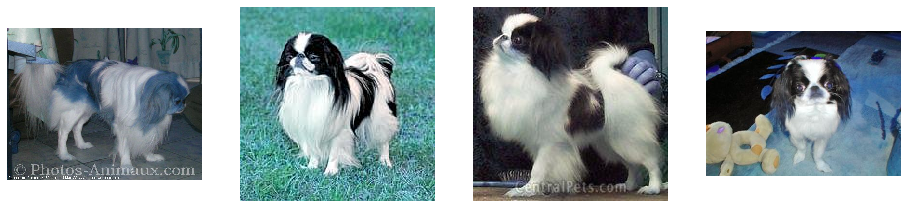

In [29]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "./dog_data/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[2])
show_dir_images(breed_list[2], 4)

### 3 parts of CNN:
- convolution
- pooling 
- fully connected layer

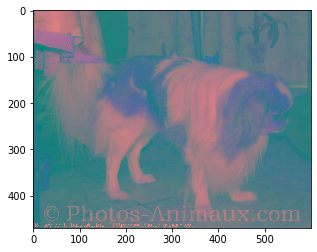

In [20]:
img_dir = "./dog_data/images/Images/{}/".format(breed_list[2])
images = os.listdir(img_dir)[:12]
images = os.listdir(img_dir)[:4]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)

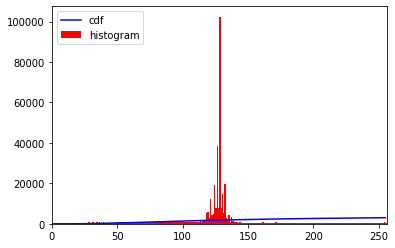

In [11]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

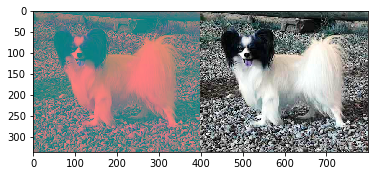

In [12]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

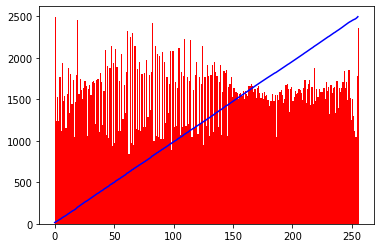

In [13]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

Augmented by rotation:


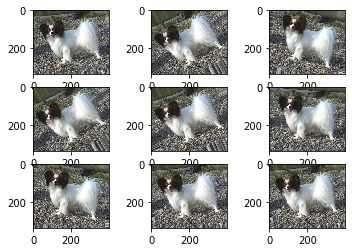

<Figure size 720x720 with 0 Axes>

In [14]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

In [15]:
num_breeds = 20 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(filtered_breeds[index])
            
    return img_lst, labels 

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))

No. of images loaded =  3633 
No. of labels loaded =  3633


In [16]:
# replace numbers with names
le = LabelEncoder()
nlabels = le.fit_transform(labels) # encode labels as number values. This prepares for categorical encoding
Y=to_categorical(nlabels,num_classes = num_breeds) # category encoding

In [17]:
#Normalization for the images
images = np.array(images)
images = images.astype(np.float32)
#labels = labels.astype(np.int32)
X_norm = images/255